<a href="https://colab.research.google.com/github/AmirMoazzami/207_final_project/blob/Soroush/W207_FinalProject_SoroushYazdani.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W207 Final Project (Baseline): Zillow Prize: Zillow’s Home Value Prediction

### Gray Selby
### Amir Moazami
### Soroush Yazdani

In this competition, Zillow is asking to predict the log-error between their Zestimate and the actual sale price, given all the features of a home. The log error is defined as

**logerror = log(Zestimate) - log(SalePrice)**

We are provided with a full list of real estate properties in three counties (Los Angeles, Orange and Ventura, California) data in 2016.

The train data has all the transactions before October 15, 2016, plus some of the transactions after October 15, 2016.

The test data in the public leaderboard has the rest of the transactions between October 15 and December 31, 2016.

The rest of the test data, which is used for calculating the private leaderboard, is all the properties in October 15, 2017, to December 15, 2017. This period is called the "sales tracking period", during which we will not be taking any submissions.

We are asked to predict 6 time points for all properties: October 2016 (201610), November 2016 (201611), December 2016 (201612), October 2017 (201710), November 2017 (201711), and December 2017 (201712).

If a property is sold multiple times within 31 days, we take the first reasonable value as the ground truth. By "reasonable", we mean if the data seems wrong, we will take the transaction that has a value that makes more sense.

We will start by importing the libraries, the data from Kaggle.com and then we performed EDA on the data set to make it cleaner. After that we performed some basic machine learning techniques for the baseline.


In [4]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

## Datasets

For this purpose we used Kaggle API to download the data into the google drive. We first install the kaggle API by:

In [12]:
pip install kaggle

Mount the Google drive so we can store our kaggle API credentials for future use.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Make a directory for kaggle at the temporary instance location on Colab drive.
Downloaded my kaggle API key (.json file).

In [8]:
! mkdir ~/.kaggle

In [9]:
!cp '/content/drive/MyDrive/Colab Notebooks/kaggle.json' ~/.kaggle/

Now change the file permission to read/write to the owner only.

In [10]:
!chmod 600 ~/.kaggle/kaggle.json

1.   Download Competition Data
Now let's download the data from Kaggle.


In [12]:
!kaggle competitions download -c zillow-prize-1

 97% 329M/340M [00:07<00:00, 29.1MB/s]
100% 340M/340M [00:07<00:00, 49.4MB/s]


2. Unzipping the Data

In [13]:
!unzip zillow-prize-1.zip

Archive:  zillow-prize-1.zip
  inflating: properties_2016.csv     
  inflating: properties_2017.csv     
  inflating: sample_submission.csv   
  inflating: train_2016_v2.csv       
  inflating: train_2017.csv          
  inflating: zillow_data_dictionary.xlsx  


In [20]:
X_train_prop_2016 = pd.read_csv('./properties_2016.csv')
display(X_train_prop_2016)
Y_train_2016=pd.read_csv('./train_2016_v2.csv')
display(Y_train_2016)


<ipython-input-20-e25c04a45b16>:1: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  X_train_prop_2016 = pd.read_csv('./properties_2016.csv')


parcelid  airconditioningtypeid  architecturalstyletypeid  \
0         10754147                    NaN                       NaN   
1         10759547                    NaN                       NaN   
2         10843547                    NaN                       NaN   
3         10859147                    NaN                       NaN   
4         10879947                    NaN                       NaN   
...            ...                    ...                       ...   
2985212  168176230                    NaN                       NaN   
2985213   14273630                    NaN                       NaN   
2985214  168040630                    NaN                       NaN   
2985215  168040830                    NaN                       NaN   
2985216  168040430                    NaN                       NaN   

         basementsqft  bathroomcnt  bedroomcnt  buildingclasstypeid  \
0                 NaN          0.0         0.0                  NaN   
1                 NaN          0.0         0.0                  NaN   
2                 NaN          0.0         0.0                  NaN   
3                 NaN          0.0         0.0                  3.0   
4                 NaN          0.0         0.0                  4.0   
...               ...          ...         ...                  ...   
2985212           NaN          NaN         NaN                  NaN   
2985213           NaN          NaN         NaN                  NaN   
2985214           NaN          NaN         NaN                  NaN   
2985215           NaN          NaN         NaN                  NaN   
2985216           NaN          NaN         NaN                  NaN   

         buildingqualitytypeid  calculatedbathnbr  decktypeid  ...  \
0                          NaN                NaN         NaN  ...   
1                          NaN                NaN         NaN  ...   
2                          NaN                NaN         NaN  ...   
3                          7.0                NaN         NaN  ...   
4                          NaN                NaN         NaN  ...   
...                        ...                ...         ...  ...   
2985212                    NaN                NaN         NaN  ...   
2985213                    NaN                NaN         NaN  ...   
2985214                    NaN                NaN         NaN  ...   
2985215                    NaN                NaN         NaN  ...   
2985216                    NaN                NaN         NaN  ...   

         numberofstories  fireplaceflag  structuretaxvaluedollarcnt  \
0                    NaN            NaN                         NaN   
1                    NaN            NaN                         NaN   
2                    NaN            NaN                    650756.0   
3                    1.0            NaN                    571346.0   
4                    NaN            NaN                    193796.0   
...                  ...            ...                         ...   
2985212              NaN            NaN                         NaN   
2985213              NaN            NaN                         NaN   
2985214              NaN            NaN                         NaN   
2985215              NaN            NaN                         NaN   
2985216              NaN            NaN                         NaN   

         taxvaluedollarcnt  assessmentyear  landtaxvaluedollarcnt  taxamount  \
0                      9.0          2015.0                    9.0        NaN   
1                  27516.0          2015.0                27516.0        NaN   
2                1413387.0          2015.0               762631.0   20800.37   
3                1156834.0          2015.0               585488.0   14557.57   
4                 433491.0          2015.0               239695.0    5725.17   
...                    ...             ...                    ...        ...   
2985212                NaN             NaN        

parcelid  logerror transactiondate
0      11016594    0.0276      2016-01-01
1      14366692   -0.1684      2016-01-01
2      12098116   -0.0040      2016-01-01
3      12643413    0.0218      2016-01-02
4      14432541   -0.0050      2016-01-02
...         ...       ...             ...
90270  10774160   -0.0356      2016-12-30
90271  12046695    0.0070      2016-12-30
90272  12995401   -0.2679      2016-12-30
90273  11402105    0.0602      2016-12-30
90274  12566293    0.4207      2016-12-30

[90275 rows x 3 columns]

In [21]:
X_test_prop_2017 = pd.read_csv('./properties_2017.csv')
display(X_test_prop_2017)
Y_test_2017=pd.read_csv('./train_2017.csv')
display(Y_test_2017)

<ipython-input-21-34bee8ce2e76>:1: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  X_test_prop_2017 = pd.read_csv('./properties_2017.csv')


parcelid  airconditioningtypeid  architecturalstyletypeid  \
0        10754147                    NaN                       NaN   
1        10759547                    NaN                       NaN   
2        10843547                    NaN                       NaN   
3        10859147                    NaN                       NaN   
4        10879947                    NaN                       NaN   
...           ...                    ...                       ...   
2985212  12170430                    NaN                       NaN   
2985213  11422430                    NaN                       NaN   
2985214  17203030                    NaN                       NaN   
2985215  14242830                    NaN                       NaN   
2985216  12766630                    NaN                       NaN   

         basementsqft  bathroomcnt  bedroomcnt  buildingclasstypeid  \
0                 NaN          0.0         0.0                  NaN   
1                 NaN          0.0         0.0                  NaN   
2                 NaN          0.0         0.0                  5.0   
3                 NaN          0.0         0.0                  3.0   
4                 NaN          0.0         0.0                  4.0   
...               ...          ...         ...                  ...   
2985212           NaN          NaN         NaN                  NaN   
2985213           NaN          NaN         NaN                  NaN   
2985214           NaN          NaN         NaN                  NaN   
2985215           NaN          NaN         NaN                  NaN   
2985216           NaN          NaN         NaN                  NaN   

         buildingqualitytypeid  calculatedbathnbr  decktypeid  ...  \
0                          NaN                NaN         NaN  ...   
1                          NaN                NaN         NaN  ...   
2                          NaN                NaN         NaN  ...   
3                          6.0                NaN         NaN  ...   
4                          NaN                NaN         NaN  ...   
...                        ...                ...         ...  ...   
2985212                    NaN                NaN         NaN  ...   
2985213                    NaN                NaN         NaN  ...   
2985214                    NaN                NaN         NaN  ...   
2985215                    NaN                NaN         NaN  ...   
2985216                    NaN                NaN         NaN  ...   

         numberofstories  fireplaceflag  structuretaxvaluedollarcnt  \
0                    NaN            NaN                         NaN   
1                    NaN            NaN                         NaN   
2                    1.0            NaN                    660680.0   
3                    1.0            NaN                    580059.0   
4                    1.0            NaN                    196751.0   
...                  ...            ...                         ...   
2985212              NaN            NaN                         NaN   
2985213              NaN            NaN                         NaN   
2985214              NaN            NaN                         NaN   
2985215              NaN            NaN                         NaN   
2985216              NaN            NaN                         NaN   

         taxvaluedollarcnt  assessmentyear  landtaxvaluedollarcnt  taxamount  \
0                      9.0          2016.0                    9.0        NaN   
1                  27516.0          2015.0                27516.0        NaN   
2                1434941.0          2016.0               774261.0   20800.37   
3                1174475.0          2016.0               594416.0   14557.57   
4                 440101.0          2016.0               243350.0    5725.17   
...                    ...             ...                    ...        ...   
2985212                NaN             NaN                   

parcelid  logerror transactiondate
0      14297519  0.025595      2017-01-01
1      17052889  0.055619      2017-01-01
2      14186244  0.005383      2017-01-01
3      12177905 -0.103410      2017-01-01
4      10887214  0.006940      2017-01-01
...         ...       ...             ...
77608  10833991 -0.002245      2017-09-20
77609  11000655  0.020615      2017-09-20
77610  17239384  0.013209      2017-09-21
77611  12773139  0.037129      2017-09-21
77612  12826780  0.007204      2017-09-25

[77613 rows x 3 columns]

In [23]:
train_df = X_train_prop_2016.merge(right = Y_train_2016, how='inner', on='parcelid')
# keep a copy of the file
test_df = X_train_prop_2016.copy()
display(train_df)

parcelid  airconditioningtypeid  architecturalstyletypeid  \
0      17073783                    NaN                       NaN   
1      17088994                    NaN                       NaN   
2      17100444                    NaN                       NaN   
3      17102429                    NaN                       NaN   
4      17109604                    NaN                       NaN   
...         ...                    ...                       ...   
90270  11876798                    1.0                       NaN   
90271  12808516                    NaN                       NaN   
90272  12010248                    1.0                       NaN   
90273  14310905                    NaN                       NaN   
90274  14636609                    NaN                       NaN   

       basementsqft  bathroomcnt  bedroomcnt  buildingclasstypeid  \
0               NaN          2.5         3.0                  NaN   
1               NaN          1.0         2.0                  NaN   
2               NaN          2.0         3.0                  NaN   
3               NaN          1.5         2.0                  NaN   
4               NaN          2.5         4.0                  NaN   
...             ...          ...         ...                  ...   
90270           NaN          3.0         4.0                  NaN   
90271           NaN          2.0         3.0                  NaN   
90272           NaN          2.0         2.0                  NaN   
90273           NaN          2.5         3.0                  NaN   
90274           NaN          2.5         3.0                  NaN   

       buildingqualitytypeid  calculatedbathnbr  decktypeid  ...  \
0                        NaN                2.5         NaN  ...   
1                        NaN                1.0         NaN  ...   
2                        NaN                2.0         NaN  ...   
3                        NaN                1.5         NaN  ...   
4                        NaN                2.5         NaN  ...   
...                      ...                ...         ...  ...   
90270                    4.0                3.0         NaN  ...   
90271                    7.0                2.0         NaN  ...   
90272                    4.0                2.0         NaN  ...   
90273                    NaN                2.5         NaN  ...   
90274                    NaN                2.5         NaN  ...   

       structuretaxvaluedollarcnt  taxvaluedollarcnt  assessmentyear  \
0                        115087.0           191811.0          2015.0   
1                        143809.0           239679.0          2015.0   
2                         33619.0            47853.0          2015.0   
3                         45609.0            62914.0          2015.0   
4                        277000.0           554000.0          2015.0   
...                           ...                ...             ...   
90270                    388582.0           596082.0          2015.0   
90271                     86209.0           178408.0          2015.0   
90272                    129000.0           420000.0          2015.0   
90273                    389474.0          1215816.0          2015.0   
90274                    237048.0           471286.0          2015.0   

       landtaxvaluedollarcnt  taxamount  taxdelinquencyflag  \
0                    76724.0    2015.06                 NaN   
1                    95870.0    2581.30                 NaN   
2                    14234.0     591.64                 NaN   
3                    17305.0     682.78                 NaN   
4                   277000.0    5886.92                 NaN   
...                      ...        ...                 ...   
90270               207500.0    7335.81                 NaN   
90271                92199.0    2441.74                 NaN   
90272               291000.0    5070.41                 NaN   
90273               826342.0   12508.30          

In [24]:
train_df.shape,test_df.shape

((90275, 60), (2985217, 58))

In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Data columns (total 60 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      90275 non-null  int64  
 1   airconditioningtypeid         28781 non-null  float64
 2   architecturalstyletypeid      261 non-null    float64
 3   basementsqft                  43 non-null     float64
 4   bathroomcnt                   90275 non-null  float64
 5   bedroomcnt                    90275 non-null  float64
 6   buildingclasstypeid           16 non-null     float64
 7   buildingqualitytypeid         57364 non-null  float64
 8   calculatedbathnbr             89093 non-null  float64
 9   decktypeid                    658 non-null    float64
 10  finishedfloor1squarefeet      6856 non-null   float64
 11  calculatedfinishedsquarefeet  89614 non-null  float64
 12  finishedsquarefeet12          85596 non-null  float64
 13  f

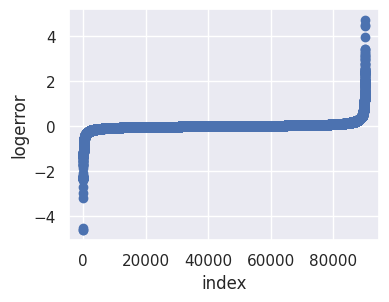

In [26]:
plt.figure(figsize=(4,3))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

## Transaction Data chart

In [31]:
pd.options.display.max_rows = 65

dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df

Count Column Type
0                       parcelid       int64
1          airconditioningtypeid     float64
2       architecturalstyletypeid     float64
3                   basementsqft     float64
4                    bathroomcnt     float64
5                     bedroomcnt     float64
6            buildingclasstypeid     float64
7          buildingqualitytypeid     float64
8              calculatedbathnbr     float64
9                     decktypeid     float64
10      finishedfloor1squarefeet     float64
11  calculatedfinishedsquarefeet     float64
12          finishedsquarefeet12     float64
13          finishedsquarefeet13     float64
14          finishedsquarefeet15     float64
15          finishedsquarefeet50     float64
16           finishedsquarefeet6     float64
17                          fips     float64
18                  fireplacecnt     float64
19                   fullbathcnt     float64
20                  garagecarcnt     float64
21               garagetotalsqft     float64
22                hashottuborspa      object
23         heatingorsystemtypeid     float64
24                      latitude     float64
25                     longitude     float64
26             lotsizesquarefeet     float64
27                       poolcnt     float64
28                   poolsizesum     float64
29                  pooltypeid10     float64
30                   pooltypeid2     float64
31                   pooltypeid7     float64
32     propertycountylandusecode      object
33         propertylandusetypeid     float64
34            propertyzoningdesc      object
35        rawcensustractandblock     float64
36                  regionidcity     float64
37                regionidcounty     float64
38          regionidneighborhood     float64
39                   regionidzip     float64
40                       roomcnt     float64
41                   storytypeid     float64
42           threequarterbathnbr     float64
43        typeconstructiontypeid     float64
44                       unitcnt     float64
45            yardbuildingsqft17     float64
46            yardbuildingsqft26     float64
47                     yearbuilt     float64
48               numberofstories     float64
49                 fireplaceflag      object
50    structuretaxvaluedollarcnt     float64
51             taxvaluedollarcnt     float64
52                assessmentyear     float64
53         landtaxvaluedollarcnt     float64
54                     taxamount     float64
55            taxdelinquencyflag      object
56            taxdelinquencyyear     float64
57           censustractandblock     float64
58                      logerror     float64
59               transactiondate      object

In [38]:
pip install ggplot


In [43]:
train_y = train_df['logerror'].values
cat_cols = ["hashottuborspa", "propertycountylandusecode", "propertyzoningdesc", "fireplaceflag", "taxdelinquencyflag"]
train_df = train_df.drop(['parcelid', 'logerror', 'transactiondate', 'transactiondate']+cat_cols, axis=1)
feat_names = train_df.columns.values

from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
model.fit(train_df, train_y)

## plot the importances ##
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()


ValueError: ignored

### Feature correlations

I need to do a better job plotting the data

In [5]:
# calculating the correlation of the train data
print(X_train.corr())
# examine each pair of features using sns.paiplot
sns.pairplot(X_train)

<ipython-input-5-750e2e9c4875>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(X_train.corr())


                      id  sudden_fever  headache  mouth_bleed  nose_bleed  \
id              1.000000      0.019627  0.039787     0.049769    0.046349   
sudden_fever    0.019627      1.000000  0.124397     0.036049    0.097796   
headache        0.039787      0.124397  1.000000     0.141593    0.101380   
mouth_bleed     0.049769      0.036049  0.141593     1.000000    0.206715   
nose_bleed      0.046349      0.097796  0.101380     0.206715    1.000000   
...                  ...           ...       ...          ...         ...   
itchiness       0.021398     -0.249787 -0.094693    -0.063708   -0.166040   
ulcers          0.009625     -0.252493 -0.104211    -0.120258   -0.175352   
toenail_loss    0.006627     -0.237154 -0.079576    -0.087354   -0.159009   
speech_problem  0.001953      0.054514  0.090628     0.070824    0.044286   
bullseye_rash   0.007583      0.031317  0.083588     0.063531    0.053200   

                muscle_pain  joint_pain  vomiting      rash  diarrhea  ... 

In [6]:
# Choose a subset of columns (these are all numeric).
columns = ['sudden_fever', 'headache', 'vomiting', 'diarrhea', 'ulcers']
features = columns
X_train = X_train[columns]
X_test = X_test[columns]

# Convert strings to numeric values, coercing missing values to nan.
for column in columns:
  X_test[column] = pd.to_numeric(X_test[column], errors='coerce')
  X_test = X_test[columns]
  X_train[column] = pd.to_numeric(X_train[column], errors='coerce')
  X_train = X_train[columns]

# The dropna function drops rows with missing value(s) by default.
X_train = X_train.dropna()
X_test = X_test.dropna()

# This leaves us with 199 examples.
display(X_train)

<ipython-input-6-2a91cebd4b7e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[column] = pd.to_numeric(X_test[column], errors='coerce')
<ipython-input-6-2a91cebd4b7e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[column] = pd.to_numeric(X_train[column], errors='coerce')


sudden_fever  headache  vomiting  diarrhea  ulcers
0             1.0       1.0       1.0       1.0     0.0
1             0.0       0.0       1.0       1.0     0.0
2             0.0       1.0       1.0       1.0     0.0
3             0.0       0.0       0.0       0.0     0.0
4             0.0       0.0       0.0       1.0     1.0
..            ...       ...       ...       ...     ...
702           0.0       0.0       0.0       0.0     0.0
703           1.0       0.0       0.0       1.0     0.0
704           1.0       0.0       0.0       1.0     0.0
705           1.0       1.0       1.0       1.0     0.0
706           1.0       1.0       1.0       0.0     1.0

[707 rows x 5 columns]

In [7]:
# We want to shuffle the order of the rows without touching the columns.
# First, we get a list of indices corresponding to the rows.
indices = np.arange(X_train.shape[0])
print('indices:', indices, '\n')

# Next, we shuffle the indices using np.random.permutation but set a random seed
# so that everyone gets the same results each time.
np.random.seed(0)
shuffled_indices = np.random.permutation(indices)
print('shuffled indices:', shuffled_indices, '\n')

# Finally, we use dataframe.reindex to change the ordering of the original
# dataframe.
X_train = X_train.reindex(shuffled_indices)
X_test = X_test.reindex(shuffled_indices)
display(X_train)

indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 2

sudden_fever  headache  vomiting  diarrhea  ulcers
317           1.0       1.0       0.0       1.0     0.0
443           1.0       0.0       1.0       1.0     1.0
187           1.0       0.0       1.0       1.0     0.0
353           0.0       0.0       0.0       0.0     0.0
570           1.0       1.0       1.0       0.0     0.0
..            ...       ...       ...       ...     ...
359           0.0       0.0       0.0       0.0     0.0
192           1.0       1.0       0.0       1.0     0.0
629           1.0       1.0       0.0       0.0     0.0
559           0.0       0.0       1.0       0.0     0.0
684           1.0       0.0       1.0       1.0     0.0

[707 rows x 5 columns]

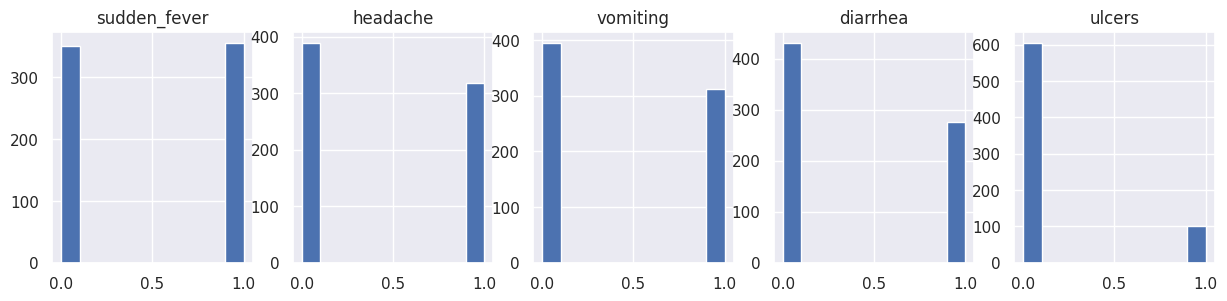

sudden_fever    headache    vomiting    diarrhea      ulcers
count    707.000000  707.000000  707.000000  707.000000  707.000000
mean       0.503536    0.449788    0.441301    0.390382    0.144272
std        0.500341    0.497825    0.496894    0.488181    0.351614
min        0.000000    0.000000    0.000000    0.000000    0.000000
25%        0.000000    0.000000    0.000000    0.000000    0.000000
50%        1.000000    0.000000    0.000000    0.000000    0.000000
75%        1.000000    1.000000    1.000000    1.000000    0.000000
max        1.000000    1.000000    1.000000    1.000000    1.000000

In [8]:
# plottig feoture histograms
plt.figure(figsize=(15, 3))
for i in range(len(columns)):
  plt.subplot(1, 5, i+1)
  plt.hist(np.array(X_train[columns[i]]))
  plt.title(columns[i])
plt.show()
# looking at the describe function
display(X_train.describe())

###Baseline


We can use either max value (which is 1) or mean for our baseline. I am not sure if using mean would help us but I put it here for now. <span style="color:chocolate"> We need to do this: </span>

1. Use max for baseline
2. Use mean for baseline.

## Build a Model

I just brought something here for now to build the model. I am still working on this section.

In [9]:
def build_model(n_classes,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01):
  """Build a multi-class logistic regression model using Keras.

  Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  # YOUR CODE HERE
  #model = NotImplemented

  model = Sequential()

  # Flatten input data
  model.add(keras.layers.Flatten(input_shape=(28, 28)))
  #model.add(Flatten(input_shape=(28, 28)))

  # Hidden layers
  for units in hidden_layer_sizes:
      model.add(Dense(units, activation=activation))

  # Output layer
  model.add(Dense(n_classes, activation='softmax'))

  # Compile the model
  if optimizer == 'SGD':
      optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  elif optimizer == 'Adam':
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  # Print the model summary
  model.summary()

  return model

In [10]:
def train_and_evaluate(hidden_layer_sizes=[],
                       activation='tanh',
                       optimizer='SGD',
                       learning_rate=0.01,
                       num_epochs=5):
  #hidden_layer_sizes = [28, 28]
  # Build the model.
  model = build_model(n_classes=10,
                      hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      learning_rate=learning_rate)


  X_train = X_train
  X_test = X_test
  Y_train = Y_train
  Y_test = Y_test


  # Train the model.
  print('Training...')
  history = model.fit(
    x=X_train,
    y=Y_train,
    epochs=num_epochs,
    batch_size=64,
    validation_split=0.1,
    verbose=0)

  # Retrieve the training metrics (after each train epoch) and the final test
  # accuracy.
  train_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  plt.plot(train_accuracy, label='train_accuracy')
  plt.plot(val_accuracy, label='validation accuracy')
  plt.xticks(range(num_epochs))
  plt.xlabel('Train epochs')
  plt.legend()
  plt.show()

  test_accuracy = model.evaluate(x=X_test, y=Y_test, verbose=0,
                                 return_dict=True)['accuracy']
  return test_accuracy

print('Test Accuracy: %1.4f' %train_and_evaluate())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


UnboundLocalError: ignored